<a href="https://colab.research.google.com/github/AvantiShri/gcp_analysis/blob/main/newcovarmetric_BulkAnalyze_powerspectrum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib
from matplotlib import pyplot as plt
from IPython.display import Image

def get_relative_power_spectrum(signal):
  ps = np.square(np.abs(scipy.fft.rfft(signal)))
  #normalize to sum to 1
  return ps/np.sum(ps)

def get_smoothed_arr(arr, windowsize):
  arr_cumsum = np.array([0] + list(np.cumsum(arr)))
  smooth_arr = arr_cumsum[windowsize:] - arr_cumsum[:-windowsize]
  return smooth_arr

def perform_powerspectrum_analysis(values, num_permutations):

  freqs = np.fft.rfftfreq(len(values), 1)
  rps = get_relative_power_spectrum(values)

  #permute the test data sequence num_permutations times to get an empirical null
  rng = np.random.RandomState(1234)
  rps_permute_2darr = np.array([get_relative_power_spectrum(rng.permutation(values))
                                  for i in range(num_permutations)])

  uniform_expectation = 1.0/len(rps)

  expected_freq = np.sum(freqs*rps)
  expected_freq_permute_arr = np.sum(freqs[None,:]*rps_permute_2darr, axis=1)

  percentile_ef = np.sum(expected_freq_permute_arr <= expected_freq)/len(expected_freq_permute_arr)

  audc = np.sum(np.abs(np.cumsum(rps - uniform_expectation)))
  audc_permute_arr = np.sum(np.abs(np.cumsum(rps_permute_2darr - uniform_expectation, axis=1)), axis=1);
  pvalue_audc = np.sum(audc_permute_arr >= audc)/len(audc_permute_arr)

  return percentile_ef, pvalue_audc, (freqs, rps)


In [2]:
def get_chisquareminus1(egg_values):
  #print("Num nan:", np.sum(np.isnan(egg_values)))
  #Radin 2023 (Anomalous entropic effects in physical systems associated
  # with collective consciousness) said "All individual samples within a matrix
  # less than 55 or greater than 145 were set to nan" so we do that here
  egg_values = np.where((egg_values < 55), np.nan, egg_values)
  egg_values = np.where((egg_values > 145), np.nan, egg_values)
  #print("Num nan post mask:", np.sum(np.isnan(egg_values)))

  num_nonnan_eggs = np.sum(np.isnan(egg_values)==False, axis=1) #get the number of non NaN eggs per row
  #If any rows are all-nan, aboort as if we dropped that row it would mess
  # up the temporal spacing
  #assert (np.sum(num_nonnan_eggs==0)==0), np.sum(num_nonnan_eggs==0)

  sum_eggs = np.nansum(egg_values, axis=1) #get the sum across all eggs - NaNs are automatically skipped
  z_sum_eggs = (sum_eggs - num_nonnan_eggs*100)/np.sqrt(num_nonnan_eggs*200*0.25) #get z scores as per a binomial dist

  return np.square(z_sum_eggs)-1, z_sum_eggs

def get_covarmetric(egg_values): #a better metric that actually gets at covariance
  egg_values = np.where((egg_values < 55), np.nan, egg_values)
  egg_values = np.where((egg_values > 145), np.nan, egg_values)

  #derivation:
  # covariance looks at the product of (X - mu_X)(Y - mu_Y)
  # if X and Y are Z-normalized, mean is 0 and this becomes a product of Z scores
  # (Z1 + Z2 + Z3)^2 = Z1^2 + Z2^2 + Z3^2 + 2Z1Z2 + 2Z1Z3 + 2Z2Z3
  # ((Z1 + Z2 + Z3)^2 - (Z1^2 + Z2^2 + Z3^2))/2 = (Z1Z2 + Z1Z3 + Z2Z3)
  # The variance of the product of zero-mean independent samples is equal to the
  # product of their variances, so under the null each Z1Z2 has variance 1.
  # Also, variance of the sum of two independent rvs is the sum of their
  # variances, so we divide by sqrt(N*(N-1)/2) where N is the number of non-nan eggs, so
  # that the variance under the null hypothesis is the same for all rows.

  z_indiv_eggs = (egg_values - 100)/np.sqrt(50) #z scores for individual eggs
  sum_sq_z_indiv_eggs = np.nansum(np.square(z_indiv_eggs), axis=1)
  sq_sum_z_indiv_eggs = np.square(np.nansum(z_indiv_eggs, axis=1)) #sum z scores across eggs, square
  num_nonnan_eggs = np.sum(np.isnan(egg_values)==False, axis=1)
  covar_metric = (sq_sum_z_indiv_eggs - sum_sq_z_indiv_eggs)/(2*np.sqrt(num_nonnan_eggs*(num_nonnan_eggs-1)/2))

  return covar_metric

In [3]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import json

%cd /content/drive/MyDrive/GCP_data

event_to_sumcsm1pval = json.load(open("event_to_sumcsm1pval.json"))

events_sorted_by_pval = sorted(event_to_sumcsm1pval.items(), key=lambda x: x[1])

for (event, pval) in events_sorted_by_pval[:100]:
  metadata = json.load(open("extracted/"+event+"_metadata.json"))
  event_name = metadata["Name"]
  print(event,event_name, pval)

/content/drive/MyDrive/GCP_data
Event391 Internat Day Peace 0.0008192443394802185
Event289 Meditations Valentines Day 0.002569859448349643
Event487 September 21 0.003153268038066148
Event217 Indonesian Earthquake 0.0032705236405630167
Event203 Baghdad Bridge Stampede 0.007938503795130725
Event472 Mandela Dies 0.008229306940944703
Event360 Brazilian Mudslides 0.012434298335079697
Event266 Obama Wins Nomination 0.014699315651582556
Event395 Steve Jobs Dies 0.015513261511045151
Event341 Chilean Miners Alive 0.0159787032720784
Event199 Oraworld Resonance 0.016077254762331683
Event437 Dr. Tomorrow Passes 0.01899878662499621
Event413 Mogadishu Bombing 0.01933102456739566
Event56 Pierre Trudeau Funeral 0.021572192676071245
Event205 Bali Bombing 2 0.022006592782255807
Event324 Health Care is Law 0.02369816101463118
Event272 Palin Acceptance 080903 0.023929771799067412
Event197 Pope Paul's Funeral 0.02405880370764557
Event183 Russian School Hostage Crisis 0.02484189157168082
Event198 Prince Cha

In [5]:
%matplotlib inline

import glob
import json
import numpy as np
import scipy
from matplotlib import pyplot as plt

%cd /content/drive/MyDrive/GCP_data

NUM_PERMUTATIONS = 1000

csm1_zscores = {"test": [], "control1": [], "control2": []}
covarmetric_zscores = {"test": [], "control1": [], "control2": []}
percentiles_ef_csm1 = {"test": [], "control1": [], "control2": []}
pvals_audc_csm1 = {"test": [], "control1": [], "control2": []}
percentiles_ef_covarmetric = {"test": [], "control1": [], "control2": []}
pvals_audc_covarmetric = {"test": [], "control1": [], "control2": []}
percentiles_ef_merged = {"test": [], "control1": [], "control2": []}
pvals_audc_merged = {"test": [], "control1": [], "control2": []}

event_count = 0

for (event, pval) in events_sorted_by_pval[:100]:
  metadata = json.load(open("extracted/"+event+"_metadata.json"))
  event_name = metadata["Name"]

  event_count += 1
  print("\n--------------------------------")
  print("Event Count:",event_count,event,event_name,pval)

  for spanname in ['test', 'control1', 'control2']:
    print("span:", spanname)
    egg_values = np.load("extracted/"+event+"_"+spanname+"_eggvalues.npy")

    csm1, z_sum_eggs = get_chisquareminus1(egg_values)
    covarmetric = get_covarmetric(egg_values)

    #for each of the csm1 and covarmetric scores, we will sum across the
    # duration. Since the events are at least an hour long, this will
    # be a sum of at least 3600 random variables with mean 0 and variance
    # 2 (for csm1) and 1 (for covarmetric),
    # that are iid under the null hypothesis. By the central limit theorem,
    # their sum should be Gaussian with mean 0 and variance = len(timeseries)
    # Dividing by sqrt(len(timeseries)) yields a Z score.
    csm1_zscore = np.sum(csm1)/np.sqrt(2*len(csm1))
    covarmetric_zscore = np.sum(covarmetric)/np.sqrt(len(covarmetric))
    print(spanname,"csm1 z score       :", csm1_zscore)
    print(spanname,"covarmetric z score:", covarmetric_zscore)
    csm1_zscores[spanname].append(csm1_zscore)
    covarmetric_zscores[spanname].append(covarmetric_zscore)

    #plot csm1 vals for context
    #%matplotlib inline
    #plt.figure(figsize=(10,2))
    #plt.plot(np.cumsum(csm1))
    #plt.show()

    (percentile_ef_csm1, pval_audc_csm1, _) = (
        perform_powerspectrum_analysis(csm1, NUM_PERMUTATIONS))
    (percentile_ef_covarmetric, pval_audc_covarmetric, _) = (
        perform_powerspectrum_analysis(covarmetric, NUM_PERMUTATIONS))
    (percentile_ef_merged, pval_audc_merged, _) = (
        perform_powerspectrum_analysis((csm1/np.sqrt(2) + covarmetric)/2, NUM_PERMUTATIONS))
    print(spanname,"ef percentile csm1       :", percentile_ef_csm1)
    print(spanname,"ef percentile covarmetric:", percentile_ef_covarmetric)
    print(spanname,"ef percentile merged     :", percentile_ef_merged)
    print(spanname,"audc pval csm1           :", pval_audc_csm1)
    print(spanname,"audc pval covarmetric    :", pval_audc_covarmetric)
    print(spanname,"audc pval merged         :", pval_audc_merged)
    percentiles_ef_csm1[spanname].append(percentile_ef_csm1)
    pvals_audc_csm1[spanname].append(pval_audc_csm1)
    percentiles_ef_covarmetric[spanname].append(percentile_ef_covarmetric)
    pvals_audc_covarmetric[spanname].append(pval_audc_covarmetric)
    percentiles_ef_merged[spanname].append(percentile_ef_merged)
    pvals_audc_merged[spanname].append(pval_audc_merged)



/content/drive/MyDrive/GCP_data

--------------------------------
Event Count: 1 Event391 Internat Day Peace 0.0008192443394802185
span: test
test csm1 z score       : 3.148966694327055
test covarmetric z score: 3.058467044848555
test ef percentile csm1       : 0.359
test ef percentile covarmetric: 0.464
test ef percentile merged     : 0.411
test audc pval csm1           : 0.681
test audc pval covarmetric    : 0.802
test audc pval merged         : 0.763
span: control1
control1 csm1 z score       : 0.6832212654517521
control1 covarmetric z score: 0.5206296565229517
control1 ef percentile csm1       : 0.055
control1 ef percentile covarmetric: 0.054
control1 ef percentile merged     : 0.056
control1 audc pval csm1           : 0.102
control1 audc pval covarmetric    : 0.105
control1 audc pval merged         : 0.102
span: control2
control2 csm1 z score       : -1.659478481923689
control2 covarmetric z score: -1.5114227673250957
control2 ef percentile csm1       : 0.599
control2 ef percentil

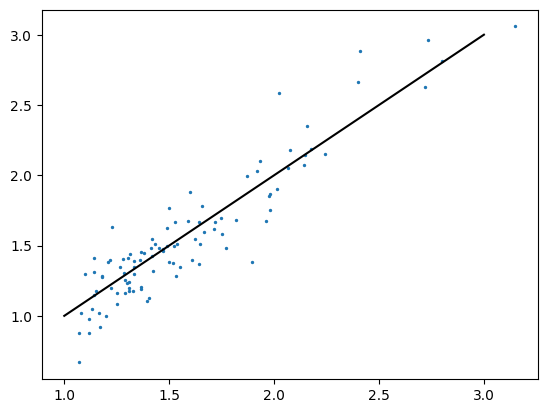

In [18]:
%matplotlib inline
plt.scatter(csm1_zscores["test"], covarmetric_zscores["test"], s=2)
plt.plot([1,3],[1,3], color="black")
plt.show()

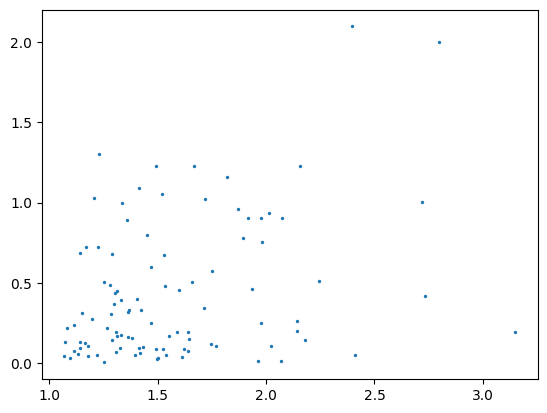

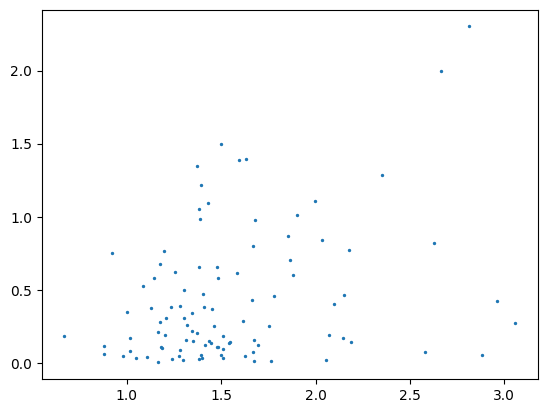

In [27]:
plt.scatter(csm1_zscores["test"], -np.log10(1-np.array(percentiles_ef_csm1["test"])), s=2)
plt.show()
plt.scatter(covarmetric_zscores["test"], -np.log10(1-np.array(percentiles_ef_covarmetric["test"])), s=2)
plt.show()
#plt.scatter(csm1_zscores["control1"], -np.log10(1-np.array(percentiles_ef_csm1["control2"])), s=2)
#plt.show()
#plt.scatter(covarmetric_zscores["control1"], -np.log10(1-np.array(percentiles_ef_covarmetric["control2"])), s=2)
#plt.show()

In [8]:
import json

prefix = "/content/drive/MyDrive/GCP_data/analysis/nperm"+str(NUM_PERMUTATIONS)+"_"

#save the pvals
open(prefix+"percentilesef_csm1.json","w").write(json.dumps(percentiles_ef_csm1, indent=4))
open(prefix+"pvalsaudc_csm1.json","w").write(json.dumps(pvals_audc_csm1, indent=4))
open(prefix+"percentilesef_covarmetric.json","w").write(json.dumps(percentiles_ef_covarmetric, indent=4))
open(prefix+"pvalsaudc_covarmetric.json","w").write(json.dumps(pvals_audc_covarmetric, indent=4))
open(prefix+"percentilesef_merged.json","w").write(json.dumps(percentiles_ef_merged, indent=4))
open(prefix+"pvalsaudc_merged.json","w").write(json.dumps(pvals_audc_merged, indent=4))

4539

In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/GCP_data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/GCP_data


In [9]:
import json
import numpy as np
import scipy

NUM_PERMUTATIONS = 1000

def get_meta_pval(pvals):
  minpval = 1.0/NUM_PERMUTATIONS
  pvals = np.maximum(np.array(pvals), minpval)
  chisquare_stat = -2*np.sum(np.log(pvals))
  deg_freedom = 2*len(pvals)
  return (1 - scipy.stats.chi2.cdf(chisquare_stat, df=deg_freedom))

#load the pvals in case we want to remake the plots without rerunning the prev stuff
prefix = "/content/drive/MyDrive/GCP_data/analysis/nperm"+str(NUM_PERMUTATIONS)+"_"
percentiles_ef_csm1 = json.load(open(prefix+"percentilesef_csm1.json"))
pvals_audc_csm1 = json.load(open(prefix+"pvalsaudc_csm1.json"))
percentiles_ef_covarmetric = json.load(open(prefix+"percentilesef_covarmetric.json"))
pvals_audc_covarmetric = json.load(open(prefix+"pvalsaudc_covarmetric.json"))
percentiles_ef_merged = json.load(open(prefix+"percentilesef_merged.json"))
pvals_audc_merged = json.load(open(prefix+"pvalsaudc_merged.json"))

num permutations: 1000
test pval: 0.043
control1 pval: 0.59
control2 pval: 0.131


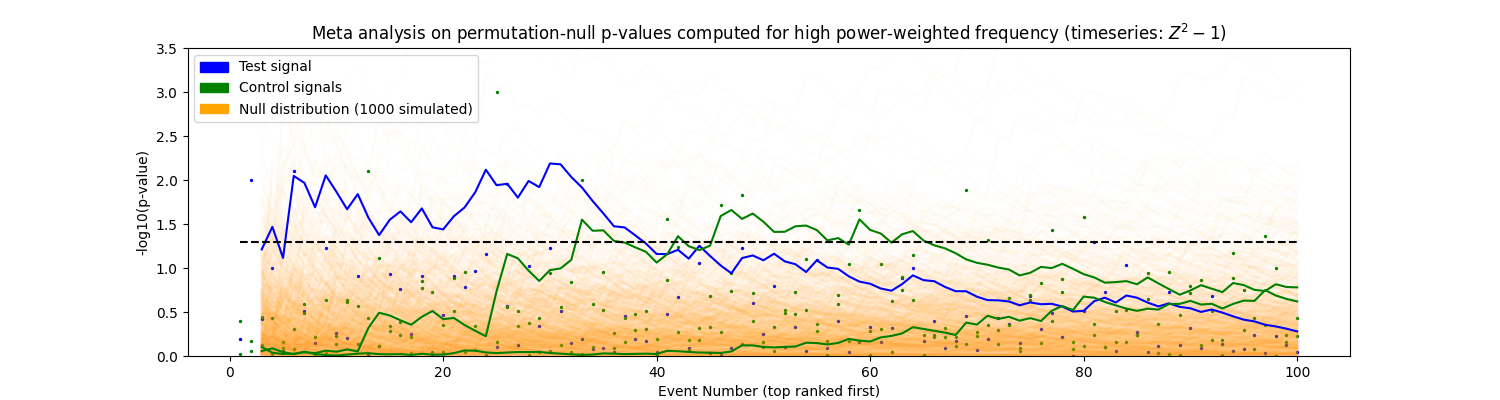

In [10]:
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
from IPython.display import Image

#plot how the meta pvalue changes with samples

def get_iterative_metapvals(pvals):
 return np.array([(get_meta_pval(pvals[:i+1])) for i in range(len(pvals))])

min_meta = 3 # start the x axis here, min num to include in metaanalysis
max_meta = len(percentiles_ef_csm1["test"]) #where to stop the plot

def make_meta_trend_plot(title, test_pvals, control1_pvals, control2_pvals):
  %matplotlib inline

  xaxis_slice = list(range(min_meta,max_meta+1))
  xaxis_full = list(range(1,max_meta+1))

  #floor p values at the lowest detectable
  test_pvals, control1_pvals, control2_pvals = [
      np.maximum(arr, 1.0/NUM_PERMUTATIONS) for arr in
       [test_pvals, control1_pvals, control2_pvals]]

  test_metapvals = -np.log10(get_iterative_metapvals(test_pvals))
  control1_metapvals = -np.log10(get_iterative_metapvals(control1_pvals))
  control2_metapvals = -np.log10(get_iterative_metapvals(control2_pvals))

  theslice = slice(min_meta-1, max_meta)

  handles = []

  rng = np.random.RandomState(1234)
  simulated_metapvals_arr = np.array([-np.log10(
      get_iterative_metapvals(
        np.maximum(rng.uniform(size=len(test_pvals)), 1.0/NUM_PERMUTATIONS)
      ) )
        for i in range(1000)])

  maxsimmetapval_arr = np.max(simulated_metapvals_arr[:,theslice], axis=1)
  maxtestmetapval = np.max(test_metapvals[theslice])
  maxcontrol1metapval = np.max(control1_metapvals[theslice])
  maxcontrol2metapval = np.max(control2_metapvals[theslice])

  print("test pval:", np.sum(maxtestmetapval < maxsimmetapval_arr)/len(maxsimmetapval_arr))
  print("control1 pval:", np.sum(maxcontrol1metapval < maxsimmetapval_arr)/len(maxsimmetapval_arr))
  print("control2 pval:", np.sum(maxcontrol2metapval < maxsimmetapval_arr)/len(maxsimmetapval_arr))

  matplotlib.use('agg')
  fig = plt.figure(figsize=(15,4))
  for simulated_metapvals in simulated_metapvals_arr:
    plt.plot(xaxis_slice, simulated_metapvals[theslice], color="orange", alpha=0.02)

  handles.append(plt.scatter(xaxis_full, -np.log10(test_pvals[:max_meta]), color="blue", s=2))
  handles.append(plt.scatter(xaxis_full, -np.log10(control1_pvals[:max_meta]), color="green", s=2))
  plt.scatter(xaxis_full, -np.log10(control2_pvals[:max_meta]), color="green", s=2)

  handles.append(plt.plot(xaxis_slice, test_metapvals[theslice], color="blue"))
  handles.append(plt.plot(xaxis_slice, control1_metapvals[theslice], color="green"))
  plt.plot(xaxis_slice, control2_metapvals[theslice], color="green")

  plt.plot([min(xaxis_full), max(xaxis_full)],
           [-np.log10(0.05), -np.log10(0.05)],
           color="black", linestyle="--")
  plt.ylim(0,3.5)
  plt.xlabel("Event Number (top ranked first)")
  plt.ylabel("-log10(p-value)")
  plt.title(title)
  plt.legend(handles=[mpatches.Patch(color='blue', label='Test signal'),
                    mpatches.Patch(color='green', label='Control signals'),
                    mpatches.Patch(color='orange', label='Null distribution (1000 simulated)')],
             loc="upper left")
  fig.savefig('metapval.png')
  plt.close(fig)
  plt.clf()

print("num permutations:",NUM_PERMUTATIONS)

make_meta_trend_plot("Meta analysis on permutation-null p-values computed for high power-weighted frequency (timeseries: $Z^2 -1$)",
                     test_pvals=1-np.array(percentiles_ef_csm1["test"]),
                     control1_pvals=1-np.array(percentiles_ef_csm1["control1"]),
                     control2_pvals=1-np.array(percentiles_ef_csm1["control2"]))
Image("metapval.png")

test pval: 0.116
control1 pval: 0.773
control2 pval: 0.406


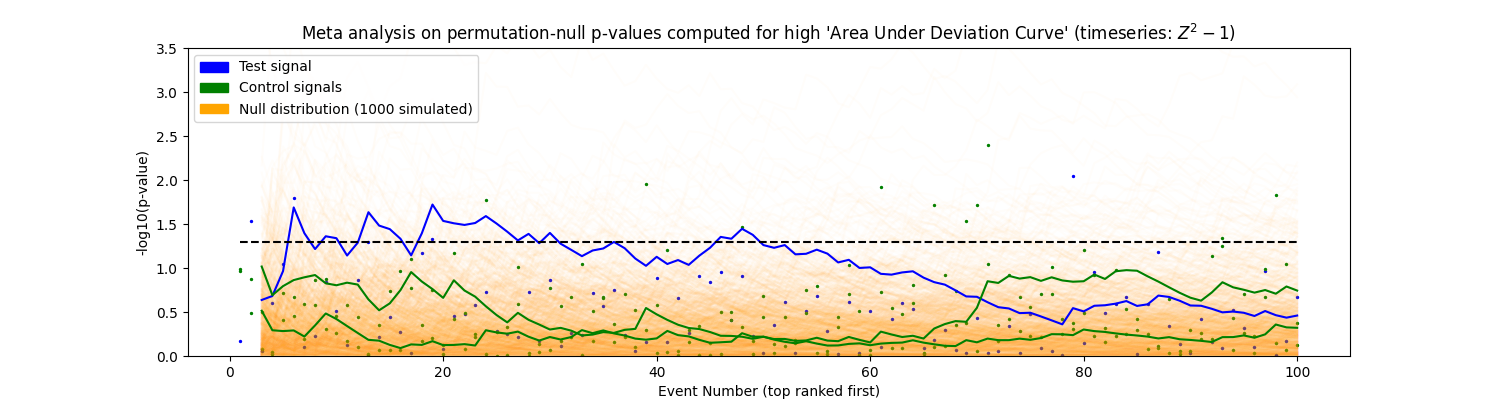

In [11]:
make_meta_trend_plot("Meta analysis on permutation-null p-values computed for high 'Area Under Deviation Curve' (timeseries: $Z^2 - 1$)",
                     test_pvals=np.array(pvals_audc_csm1["test"]),
                     control1_pvals=np.array(pvals_audc_csm1["control1"]),
                     control2_pvals=1-np.array(pvals_audc_csm1["control2"]))
Image("metapval.png")

test pval: 0.05
control1 pval: 0.624
control2 pval: 0.145


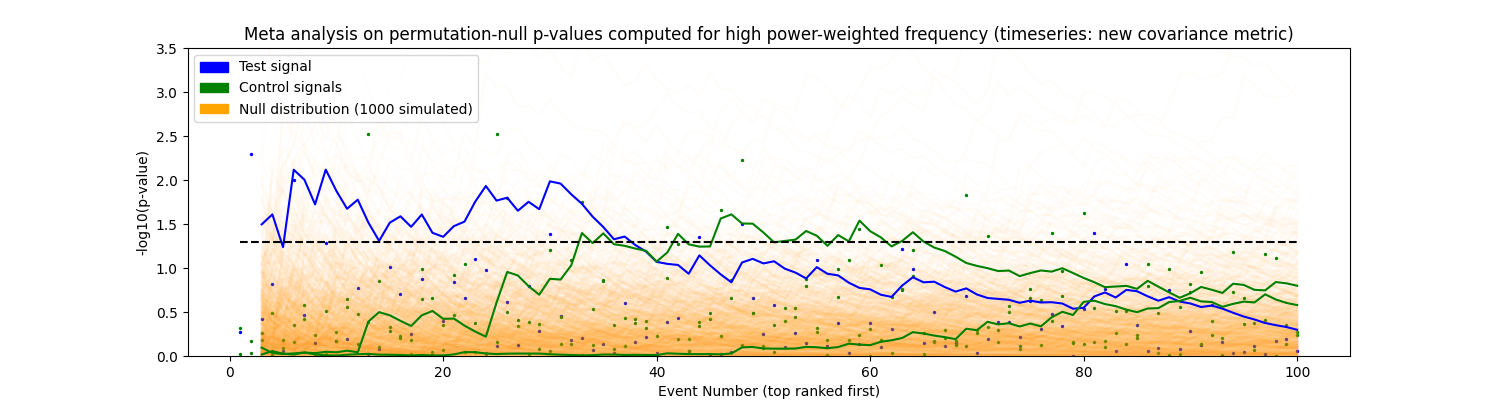

In [12]:
make_meta_trend_plot("Meta analysis on permutation-null p-values computed for high power-weighted frequency (timeseries: new covariance metric)",
                     test_pvals=1-np.array(percentiles_ef_covarmetric["test"]),
                     control1_pvals=1-np.array(percentiles_ef_covarmetric["control1"]),
                     control2_pvals=1-np.array(percentiles_ef_covarmetric["control2"]))
Image("metapval.png")

test pval: 0.178
control1 pval: 0.642
control2 pval: 0.357


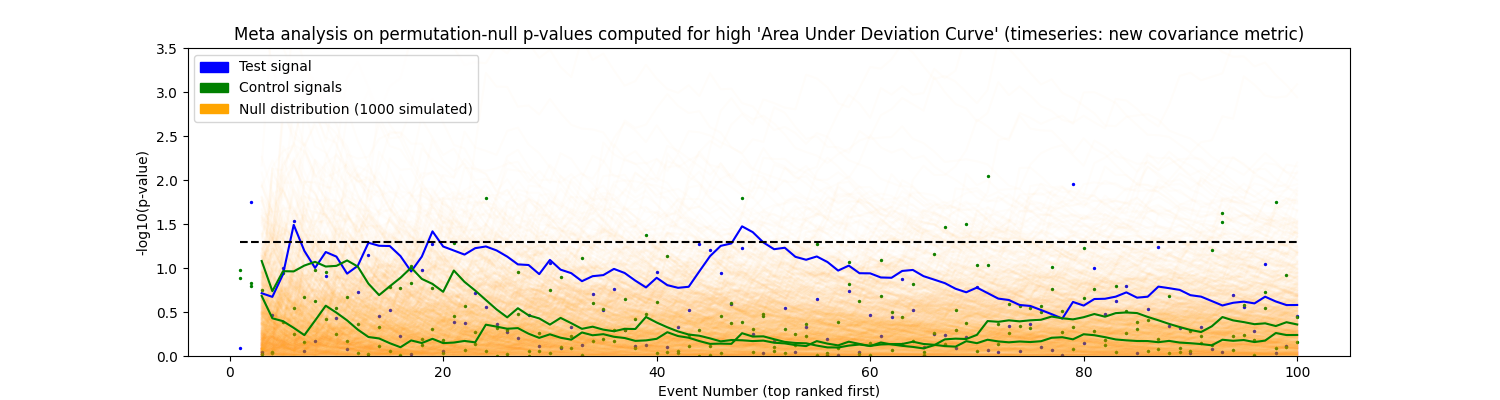

In [13]:
make_meta_trend_plot("Meta analysis on permutation-null p-values computed for high 'Area Under Deviation Curve' (timeseries: new covariance metric)",
                     test_pvals=np.array(pvals_audc_covarmetric["test"]),
                     control1_pvals=np.array(pvals_audc_covarmetric["control1"]),
                     control2_pvals=1-np.array(pvals_audc_covarmetric["control2"]))
Image("metapval.png")

test pval: 0.047
control1 pval: 0.629
control2 pval: 0.123


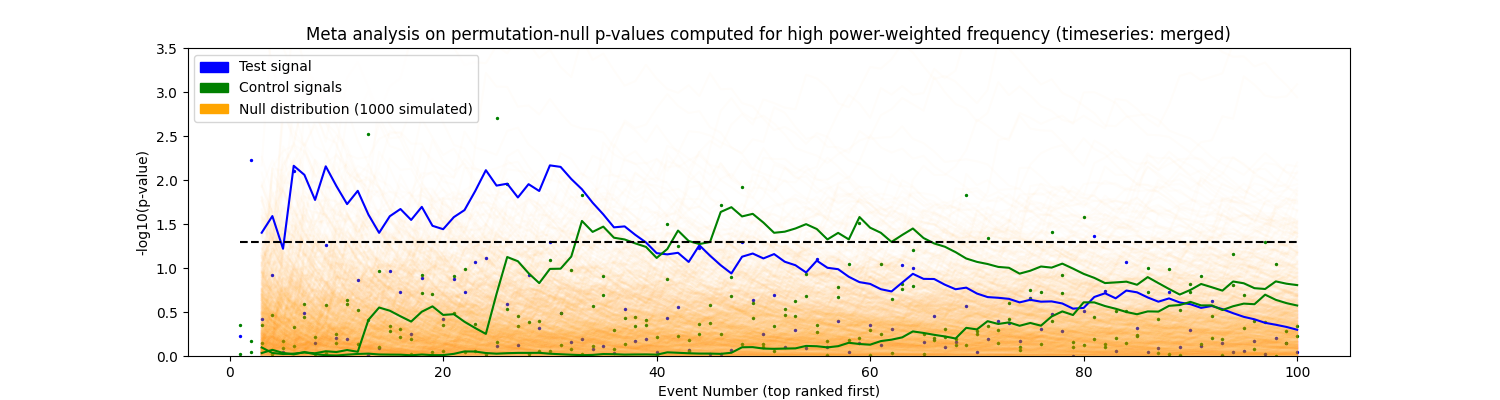

In [14]:
make_meta_trend_plot("Meta analysis on permutation-null p-values computed for high power-weighted frequency (timeseries: merged)",
                     test_pvals=1-np.array(percentiles_ef_merged["test"]),
                     control1_pvals=1-np.array(percentiles_ef_merged["control1"]),
                     control2_pvals=1-np.array(percentiles_ef_merged["control2"]))
Image("metapval.png")

test pval: 0.151
control1 pval: 0.709
control2 pval: 0.359


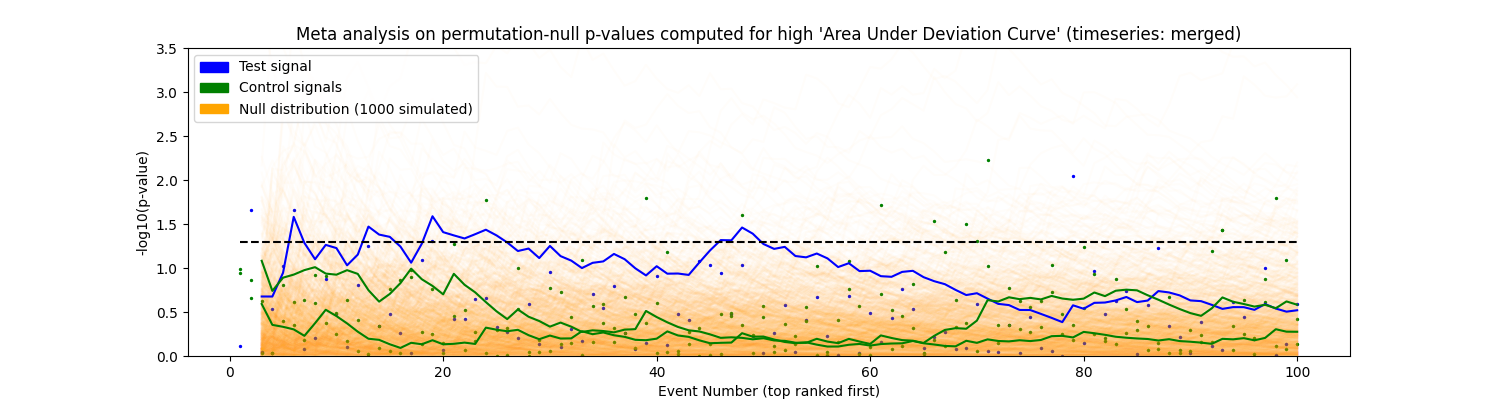

In [15]:
make_meta_trend_plot("Meta analysis on permutation-null p-values computed for high 'Area Under Deviation Curve' (timeseries: merged)",
                     test_pvals=np.array(pvals_audc_merged["test"]),
                     control1_pvals=np.array(pvals_audc_merged["control1"]),
                     control2_pvals=1-np.array(pvals_audc_merged["control2"]))
Image("metapval.png")